In [2]:
import os
import sys
sys.path.insert(0, os.path.abspath('../../'))
from utils.gpu_util import set_gpu

import matplotlib.pyplot as plt
#from preprocess.tf_records import TFRecordIO 
import preprocess.tf_records as tfr

from utils.train_utils import load_dataset
set_gpu('gpu')


In [2]:
import tensorflow as tf

In [3]:
import numpy as np

In [4]:
from augmentation.augmentation import normalization, augment_with_flip, augment_with_rotate, augment_patches

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

### To read sample images from tfrecord, please check that the entry in configuration.json

tfrecords->1h = false
training-> img_size_x, img_size,y must follow the same image size of io_path

In [13]:
def normalize(x,y):

    x = tf.cast(x, tf.float32)
    x /= 255.0

    return x,y

def rotate(x: tf.Tensor,y) -> tf.Tensor:
    """Rotation augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """

    return tf.image.rot90(x, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)),y

def augment_map(x, y):
    """
    Augmentation operations    
    """
    print("Augmented")
    
    # Rotate counterclockwise by 90 degrees num_rot times.
    #x = tf.image.rot90(x, k=1)

    # Randomly flip the image vertically with prob 0.5.
    x = tf.image.random_flip_up_down(x)

    # Randomly flip the image horizontally with prob 0.5.
    x = tf.image.random_flip_left_right(x)

    return x, y

def patches_map(x,y):

    #images = [[[[x * n + y + 1] for y in range(200)] for x in range(300)]]
    #image = tf.expand_dims(x, 0)
    #print(image.shape)
    x = tf.image.extract_patches(images=x,
                            sizes=[1, 200, 300, 1],
                            strides=[1, 200, 300, 1],
                            rates=[1, 1, 1, 1],
                            padding='VALID')
    
    return x, y

def patches_random(x,y):

    x = tf.image.random_crop(x, size=[200, 300, 3])
    
    return x, y

def load_dataset(data_type, batch_size, prefetch_size, normalize=True, augmentation=False):
    """
    Load tf record dataset, augmentation compatible

    Arguments:
        data_type: String type of dataset (train,valid,test)
        batch_size: Int, batch size
        prefetch_size: Integerprefetch buffer, int
        augmentation: boolean

    Returns:
        dataset, dataset_length
    """

    tfrio = tfr.TFRecordIO()
    print("Reading tfrecord...")
    dataset, dataset_len = tfrio.read_tf_record(data_type)

    dataset = dataset.shuffle(1000)#.batch(batch_size)
    
    if normalize:
        print("Normalization...")
        dataset = dataset.map(normalization)

    if augmentation:
        print("Augmentation enabled")
        dataset = dataset.map(patches_random, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        
    #dataset = dataset.shuffle(1000).prefetch(PREFETCH_SIZE).repeat().batch(BATCH_SIZE)
    #dataset = dataset.shuffle(1000).repeat().batch(batch_size)#.prefetch(prefetch_size)
    #dataset = dataset.map(rotate)#.prefetch(prefetch_size)
    #dataset = dataset.shuffle(1000)#.map(patches_map)#.batch(batch_size)#.prefetch(tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    
    
    return dataset, dataset_len

In [14]:
valid, valid_len = load_dataset('valid', 25, 1000, normalize=False, augmentation=True)

Reading tfrecord...
Augmentation enabled


In [16]:
for image, label in valid.take(1):
    print(image.shape)
    #image = tf.squeeze(image)
    
    #print(label)
    
    #patch = tf.reshape(image[0,0,:], [50, 50, 3])
    #print(patch.shape)
    #show_dof_batch(patch, label)
    #show_patch(image)

(25, 200, 300, 3)


In [17]:
def plot_patches_with_batch(image_batch):
    plt.figure(figsize=(20, 20))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n]/255)
        #plt.imshow(image_batch[n])
        
        #plt.subplots_adjust(bottom = .04, top= .3, hspace = .1, wspace=.1)
        '''
        if label_batch[n] == 0:
            plt.title("Low DoF")
        elif label_batch[n] == 1:
            plt.title("Medium DoF")
        else:
            plt.title("High DoF")
        '''
        plt.axis("off")
        plt.savefig('unsplash_sample_split.png')


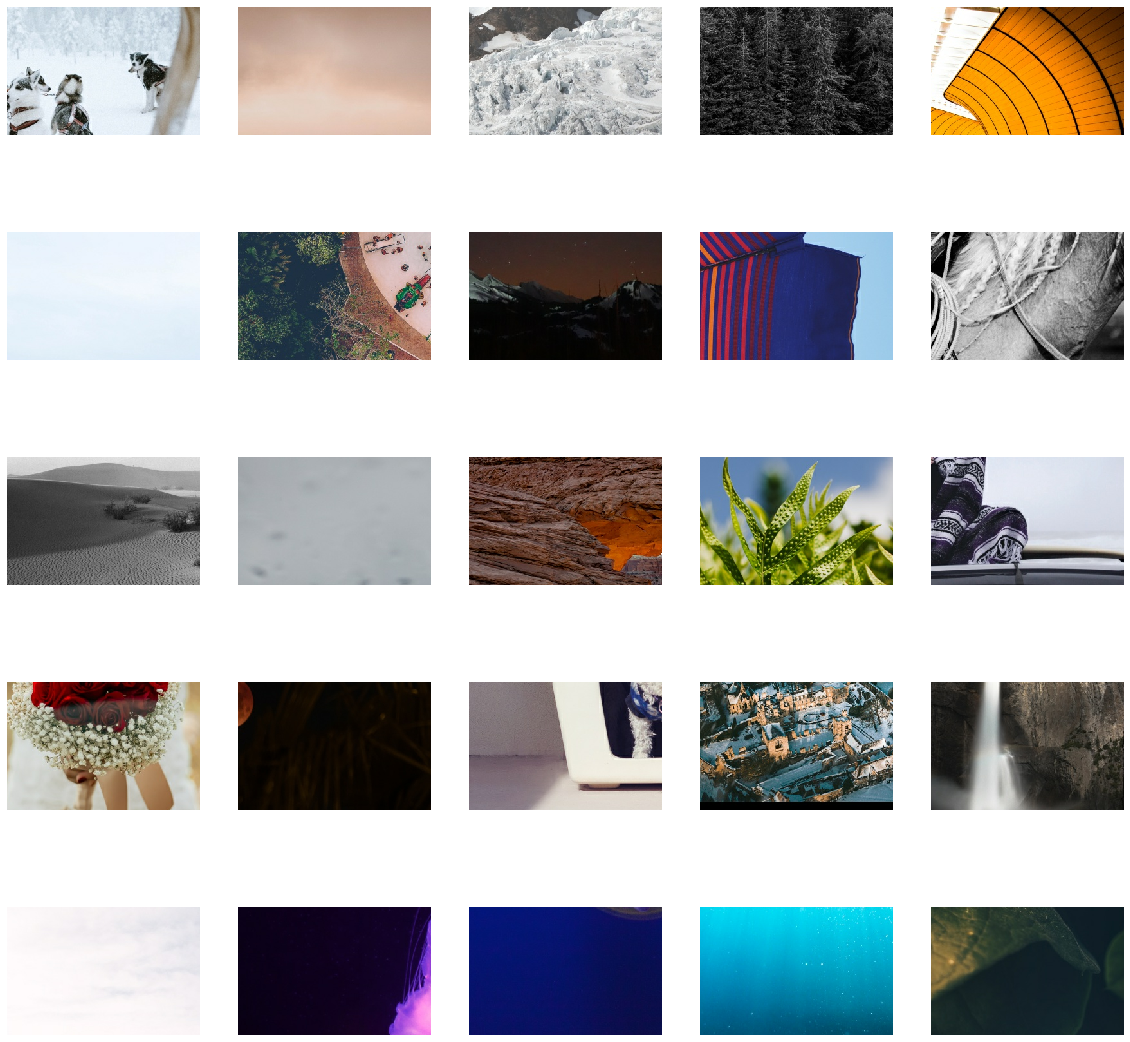

In [18]:
plot_patches_with_batch(image)

In [18]:
def plot_patches_without_batch(image_batch):
    plt.figure(figsize=(20, 20))
    for n in range(len(image_patches[0]+1)):
        ax = plt.subplot(3, 3, n + 1)
        plt.imshow(image_batch[n]/255)
        #plt.imshow(image_batch[n])
        
        #plt.subplots_adjust(bottom = .04, top= .3, hspace = .1, wspace=.1)
        '''
        if label_batch[n] == 0:
            plt.title("Low DoF")
        elif label_batch[n] == 1:
            plt.title("Medium DoF")
        else:
            plt.title("High DoF")
        '''
        plt.axis("off")
        plt.savefig('unsplash_sample_split.png')


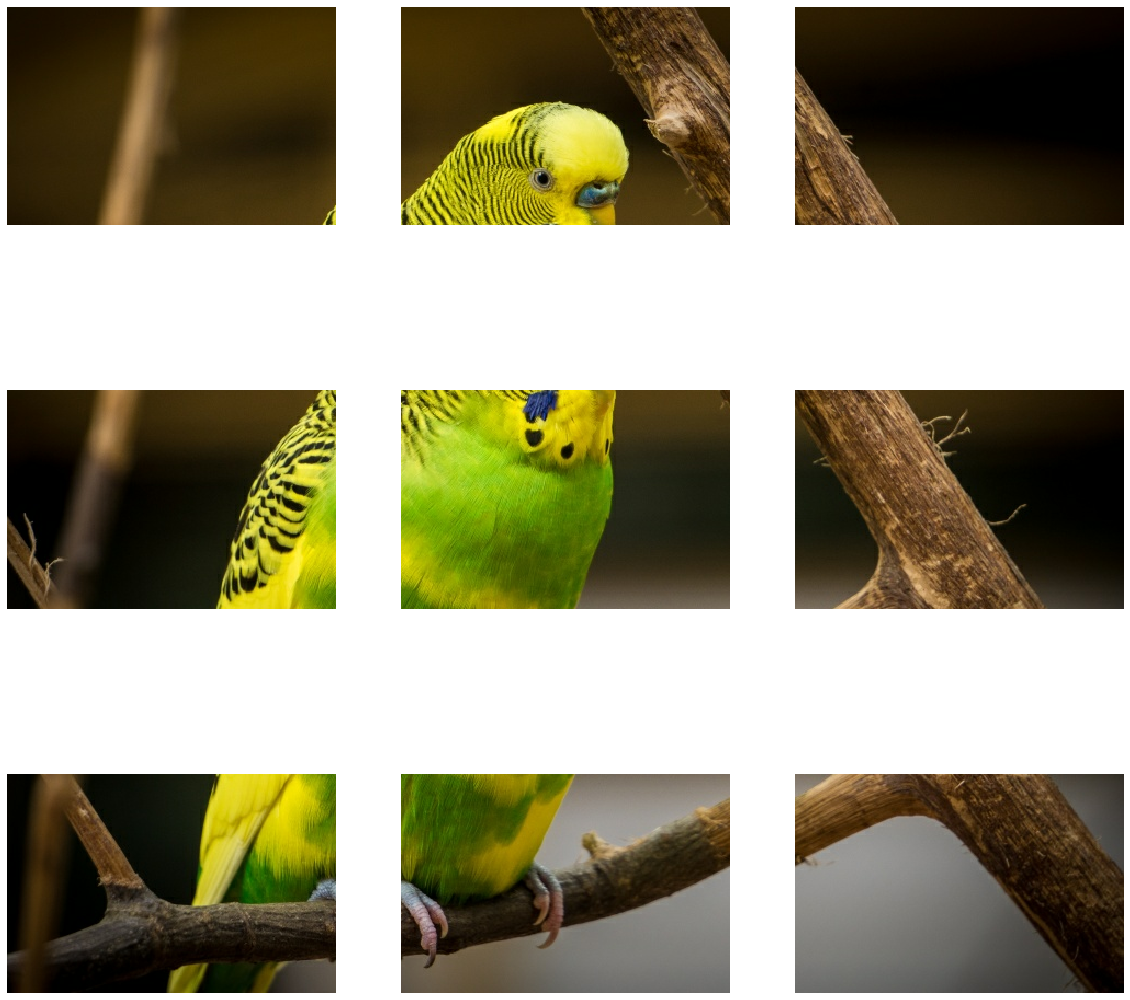

In [12]:
plot_patches_with_batch(image_patches)

In [11]:
def show_dof_batch(image_batch, label_batch):
    plt.figure(figsize=(20, 20))
    for n in range(16):
        ax = plt.subplot(4, 4, n + 1)
        plt.imshow(image_batch[n]/255)
        #plt.imshow(image_batch[n])
        
        #plt.subplots_adjust(bottom = .04, top= .3, hspace = .1, wspace=.1)
        '''
        if label_batch[n] == 0:
            plt.title("Low DoF")
        elif label_batch[n] == 1:
            plt.title("Medium DoF")
        else:
            plt.title("High DoF")
        '''
        plt.axis("off")
        #plt.savefig('unsplash_sample.png')

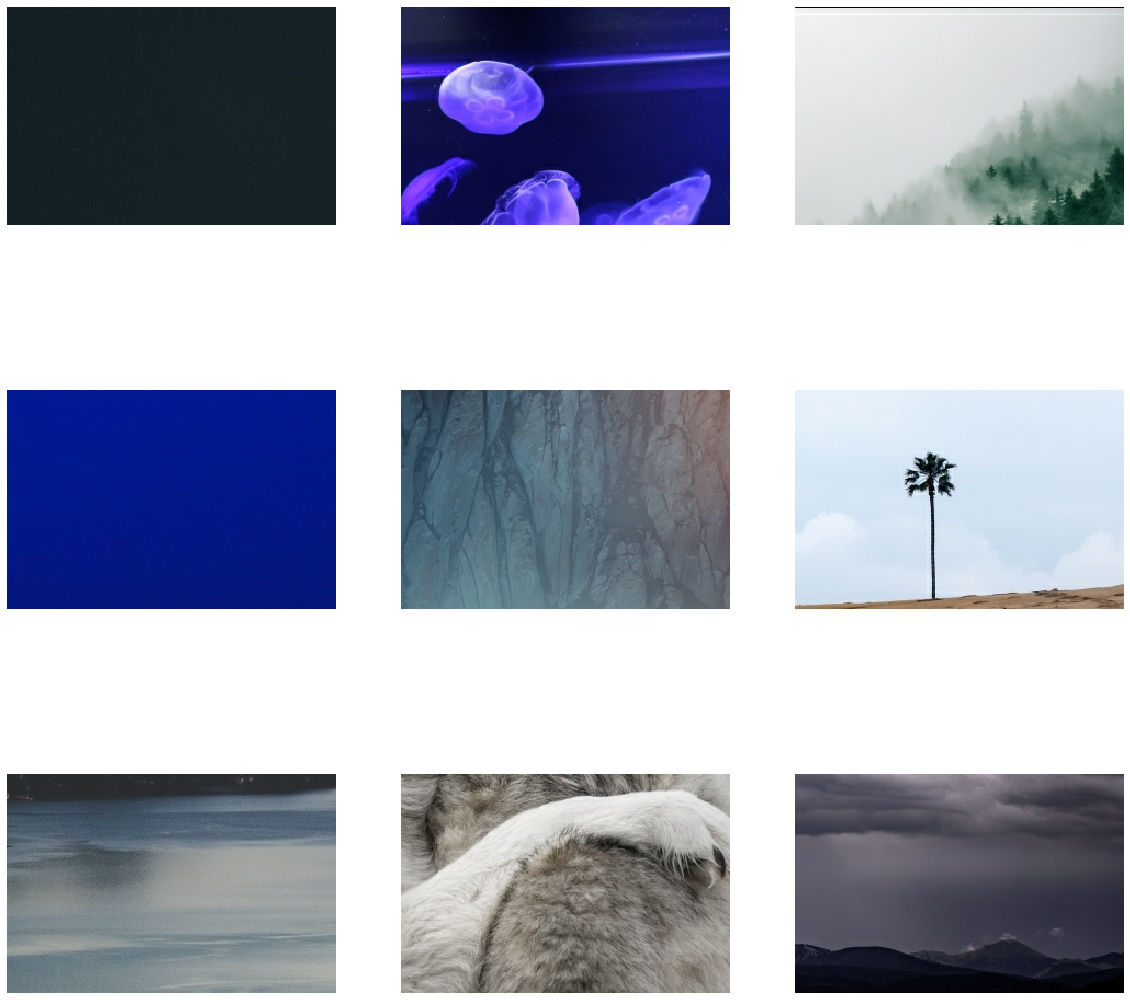

In [38]:
plot_patches_with_batch(image_patches)

### Test a single image with patch_extraction augmentation

In [8]:
testim = '1.jpg'
image_string = tf.io.read_file(testim)
timg = tf.image.decode_jpeg(image_string, channels=3)

In [20]:
# Split a 400x400 image, in 16x 100x100 patches

ksize_rows = 200
ksize_cols = 300

# strides_rows and strides_cols determine the distance between
#+ the centers of two consecutive patches.
strides_rows = 1 # 128
strides_cols = 1 # 128

# The size of sliding window
ksizes = [1, ksize_rows, ksize_cols, 1] 

# How far the centers of 2 consecutive patches are in the image
strides = [1, 200, 300, 1]

image = tf.expand_dims(timg, 0)
image = tf.image.extract_patches(images=image,
                            sizes=ksizes,
                            strides=strides,
                            rates=[1, 1, 1, 1],
                            padding='SAME')

In [18]:
def plot_patches(image_batch):
    plt.figure(figsize=(20, 20))
    for n in range(len(image_patches)):
        ax = plt.subplot(3, 3, n + 1)
        plt.imshow(image_batch[n]/255)
        #plt.imshow(image_batch[n])
        
        #plt.subplots_adjust(bottom = .04, top= .3, hspace = .1, wspace=.1)
        '''
        if label_batch[n] == 0:
            plt.title("Low DoF")
        elif label_batch[n] == 1:
            plt.title("Medium DoF")
        else:
            plt.title("High DoF")
        '''
        plt.axis("off")
        #plt.savefig('unsplash_sample_split.png')

In [21]:
image.shape

TensorShape([1, 3, 3, 180000])

In [22]:
image = tf.squeeze(image)

In [23]:
image.shape

TensorShape([3, 3, 180000])

In [24]:
#image_patches = tf.reshape(image[:,:,:], [16, 100, 100, 3]) # patches, x,y,channels
image_patches = tf.reshape(image[:,:], [9, 200, 300, 3]) # patches, x,y,channels

In [25]:
image_patches.shape

TensorShape([9, 200, 300, 3])

In [20]:
#image_patches[0][42][49]
image_patches[0][42][49]

<tf.Tensor: id=24486, shape=(3,), dtype=float32, numpy=array([50., 50., 38.], dtype=float32)>

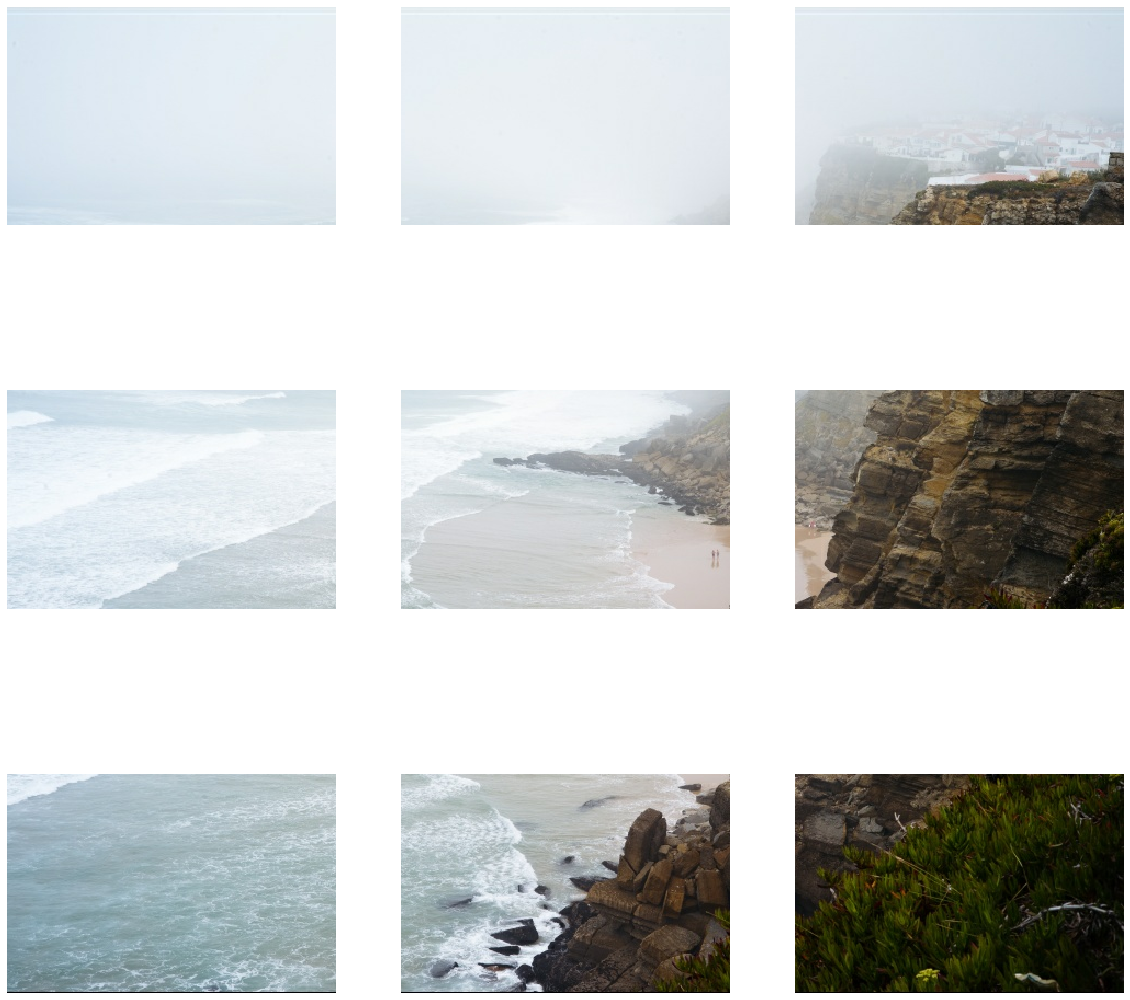

In [26]:
plot_patches(image_patches)

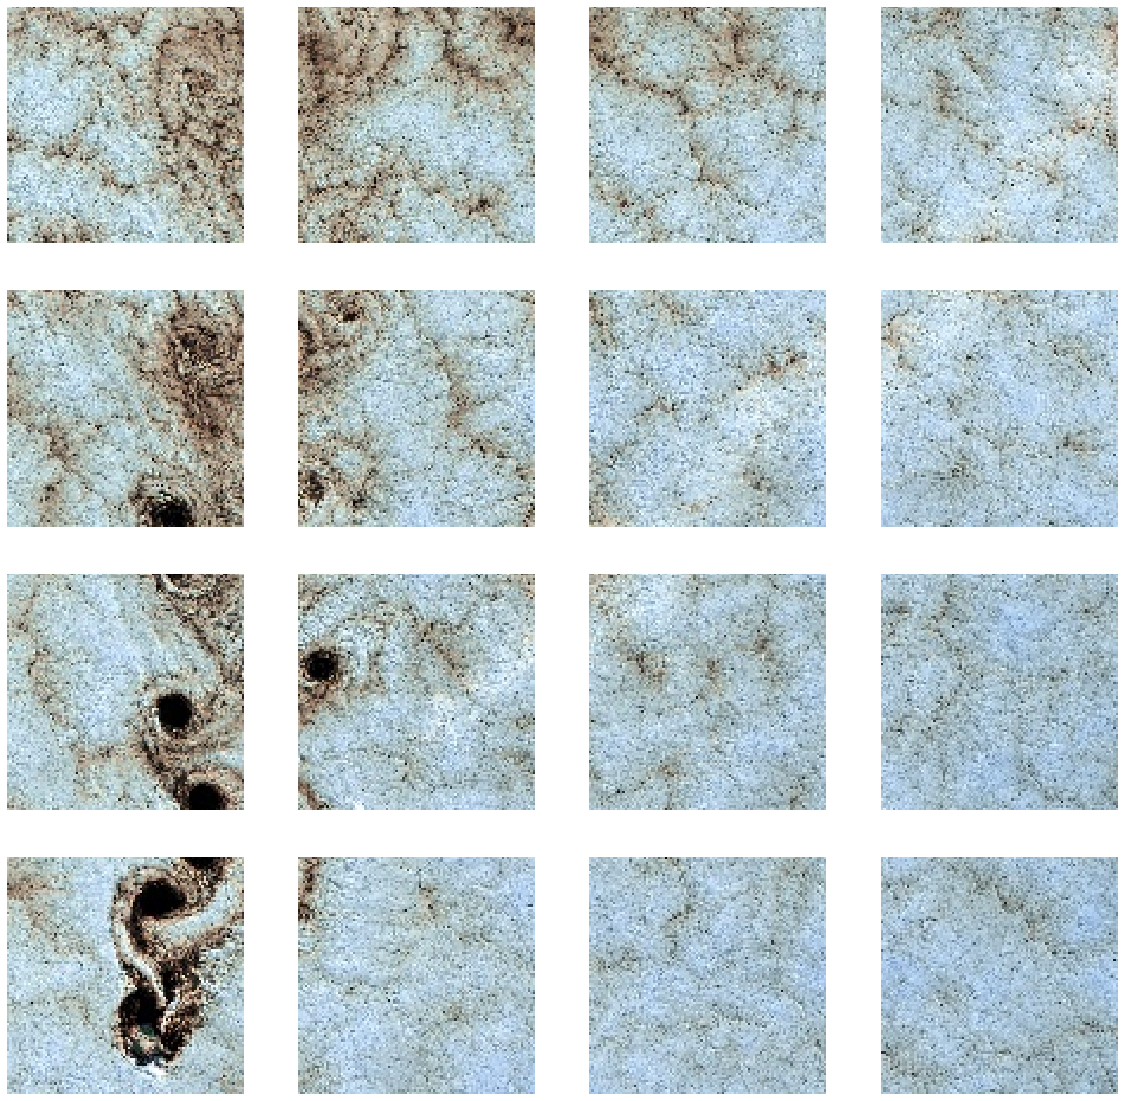

In [29]:
plot_patches(image_patches)

## Write tf records

### To select the dataset of your choice please alter configuration.json 

- .csv:
tfrecords->csv_data_path

- image path:
tfrecords->img_path

- path to write tfrecords:
tfrecords->io_path

- tfrecords->img_size_x, img_size_y

In [5]:
from configuration.config import Configuration

In [9]:
config = Configuration().get_configuration()

csv_path = config['tfrecords']['csv_data_path']
img_path = config['tfrecords']['img_path']
io_path = config['tfrecords']['io_path']

In [12]:
tfrio = TFRecordIO(csv_path,img_path,io_path)

In [6]:
# 'train', 'valid', 'test'
tfrio.write_tf_record('test')

NameError: name 'tfrio' is not defined